In [1]:
missing_packages <- character()
for (package in c(
  "GGEBiplot"
)) {
  if (!require(package, quietly = TRUE, character.only = TRUE)) {
    missing_packages <- append(missing_packages, package)
  }
}

if (length(missing_packages) > 0) {
  stop(
    sprintf(
      "Missing the following packages: %s",
      paste(missing_packages, collapse = ", ")
    ),
    call. = FALSE
  )
}


In [7]:
df <- read.delim(
  "Private_Data/cassava2.txt",
  row.names = 1
)
cat("Entries: ", nrow(df), "\n")
cat("e1: Arauca, e2: La Vega, e3: Invernadero")
head(df)


Entries:  100 
e1: Arauca, e2: La Vega, e3: Invernadero

,e1,e2,e3
,<dbl>,<dbl>,<dbl>
g1,1.36,1.29,1.41
g2,1.39,1.15,1.37
g3,1.34,0.97,1.48
g4,1.38,1.29,1.61
g5,1.61,1.15,1.30
g6,1.48,1.35,1.63


## The vector view of the GGE biplot

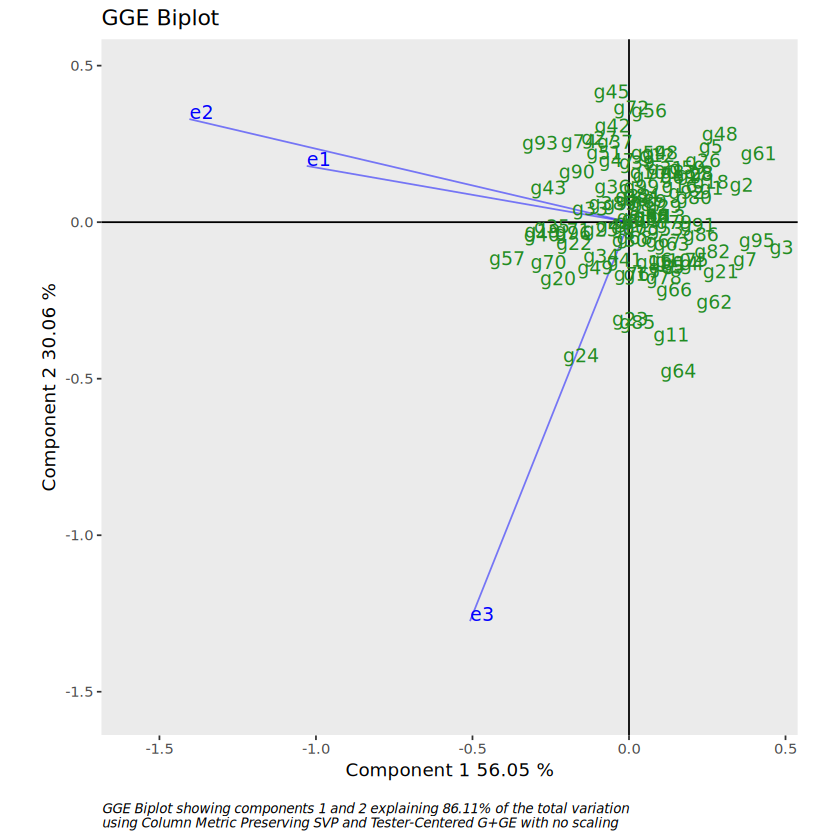

In [12]:
gge_model <- GGEModel(df)
GGEPlot(gge_model)


¿El comportamiento de los genotipos es más similar en qué ambientes?

En Arauca (e1) y La Vega (e2) se presenta el comportamiento más similar. Los ángulos entre e1 y e2 son pequeños, mostrando fuerte correlación positiva (_cos_(angulo) ≈ coeficiente de correlación (Yan, 2019)); en contraste, Invernadero (e3) tiene correlación cercana a cero con e1 y e2.